In [1]:
#! /usr/bin/env python

In [2]:
# import modules
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sklearn
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
import tensorflow as tf
import keras
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from keras.losses import mean_squared_error
from keras import metrics

In [3]:
# pull dataset
nutrition = pd.read_pickle("./Nutrition_Full_Features.pkl")

In [4]:
#drop rows with NaN
nutrition = nutrition.dropna()

In [5]:
#Data for features
X_original = nutrition.iloc[:, 11:]
y = nutrition.iloc[:, 7]
y = y.to_numpy()

In [6]:
# normalise the data by feature column
X = preprocessing.normalize(X_original, axis=0)
X = pd.DataFrame(X_original, columns = X_original.columns) # processing loses columns headers so these must be reestablished
X = X.to_numpy()

In [7]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [8]:
#building keras Neural Network model

from keras.layers import Dense, Activation
from keras.models import Sequential
from keras import losses

# model type
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(8, activation = 'relu', input_dim = 40))

# Adding the second hidden layer
model.add(Dense(units = 16, activation = 'relu'))

# Could create for loop to check number of layers

#avoids overfitting
#https://keras.io/api/layers/regularization_layers/dropout/
model.add(keras.layers.Dropout(0.1))


# Adding the output layer
model.add(Dense(units = 1))


# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'mse', metrics=['accuracy'])

# Training the Model
history = model.fit(X_train, y_train, batch_size = 10, epochs = 50, validation_split=0.3)

Epoch 1/50
59/59 [==============================] - 2s 29ms/step - loss: 1685182.7500 - accuracy: 0.0029 - val_loss: 247162.0781 - val_accuracy: 0.0000e+00
Epoch 2/50
59/59 [==============================] - 0s 3ms/step - loss: 625067.9836 - accuracy: 7.9829e-04 - val_loss: 75765.6406 - val_accuracy: 0.0000e+00
Epoch 3/50
59/59 [==============================] - 0s 2ms/step - loss: 151829.9427 - accuracy: 0.0015 - val_loss: 23485.5098 - val_accuracy: 0.0000e+00
Epoch 4/50
59/59 [==============================] - 0s 3ms/step - loss: 108195.2297 - accuracy: 0.0031 - val_loss: 18648.6855 - val_accuracy: 0.0000e+00
Epoch 5/50
59/59 [==============================] - 0s 2ms/step - loss: 153606.6621 - accuracy: 3.0226e-04 - val_loss: 17021.3242 - val_accuracy: 0.0000e+00
Epoch 6/50
59/59 [==============================] - 0s 3ms/step - loss: 62377.7021 - accuracy: 0.0019 - val_loss: 14599.8525 - val_accuracy: 0.0000e+00
Epoch 7/50
59/59 [==============================] - 0s 4ms/step - loss: 

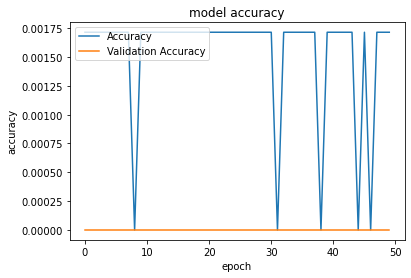

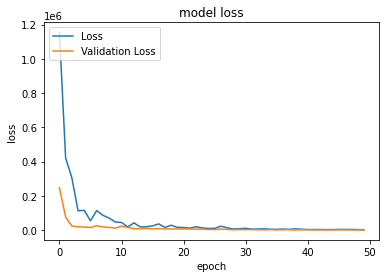

In [9]:
#plot learning curves

#accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Loss', 'Validation Loss'], loc='upper left')
plt.show()


In [10]:
#model evaluation
score = model.evaluate(X_test, y_test, verbose = 0)[1]

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 328       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                144       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 489
Trainable params: 489
Non-trainable params: 0
_________________________________________________________________


In [12]:
print('Scores without tuning: {}'.format(score))

Scores without tuning: 0.0


In [13]:
# get predicted values
y_pred = model.predict(X_test)

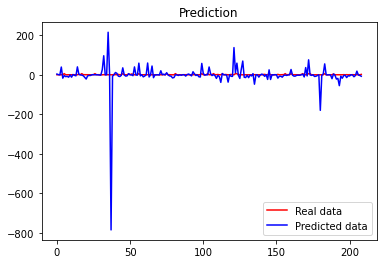

In [14]:
# plot predicted values against test values
plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend(loc='upper right')
plt.show()

In [15]:
# checking the output metrics
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 16.114538722524003
Mean Squared Error: 3737.9671164486767
Root Mean Squared Error: 61.13891654624472


In [16]:
y_mean = np.mean(y)
y_std = np.std(y)
print('Output Standard Deviation:', y_std)
print('Output Mean:', y_mean)

Output Standard Deviation: 1.6110865075846403
Output Mean: 0.8464732245681383


# Hyper Parameter Tuning Section

In [17]:
import kerastuner
from kerastuner import HyperModel

def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units', min_value=8, max_value=64, step=4), 
        activation = hp.Choice('dense_activation', 
                values=['relu', 'tanh','sigmoid','softmax']),
        input_dim = 40
        )
             
    )

    model.add(Dense(
        units=hp.Int('units', min_value=8, max_value=64, step=4), 
        activation = hp.Choice('dense_activation', 
                values=['relu', 'tanh','sigmoid','softmax'])
        )
             
    )
    
    model.add(
        keras.layers.Dropout(
            hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.1,
                    step=0.01)
        )
    )

    # Adding the output layer
    model.add(Dense(units = 1))


    model.compile(
        optimizer = hp.Choice('dense_optimizer',
                values=['adam','SGD','rmsprop','adadelta'] ),
        loss = 'mean_squared_error',
        metrics = ['accuracy'],
    )
    return model

In [20]:
tuner = kerastuner.tuners.RandomSearch(
            build_model,
            objective='loss',
            max_trials=50,
            executions_per_trial=2,
            project_name='hp_values',
            overwrite=True)

In [21]:
tuner.search(X_train, y_train, epochs=10)

Trial 50 Complete [00h 00m 04s]
loss: 0.8484272062778473

Best loss So Far: 0.8425749838352203
Total elapsed time: 00h 03m 14s
INFO:tensorflow:Oracle triggered exit


In [27]:
#collect best hyperparameters to rebuild model
best_hp = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hp)
# Training the Model
history = model.fit(X_train, y_train, batch_size = 10, epochs = 100, validation_split=0.3)

Epoch 1/100
59/59 [==============================] - 1s 6ms/step - loss: 3.5323 - accuracy: 0.0000e+00 - val_loss: 1.3286 - val_accuracy: 0.0000e+00
Epoch 2/100
59/59 [==============================] - 0s 3ms/step - loss: 1.2824 - accuracy: 0.0000e+00 - val_loss: 1.1524 - val_accuracy: 0.0000e+00
Epoch 3/100
59/59 [==============================] - 0s 3ms/step - loss: 1.1207 - accuracy: 0.0061 - val_loss: 1.0726 - val_accuracy: 0.0000e+00
Epoch 4/100
59/59 [==============================] - 0s 2ms/step - loss: 1.0494 - accuracy: 0.0000e+00 - val_loss: 1.0575 - val_accuracy: 0.0000e+00
Epoch 5/100
59/59 [==============================] - 0s 3ms/step - loss: 1.0994 - accuracy: 8.8963e-04 - val_loss: 1.1327 - val_accuracy: 0.0000e+00
Epoch 6/100
59/59 [==============================] - 0s 3ms/step - loss: 1.0917 - accuracy: 0.0019 - val_loss: 1.0977 - val_accuracy: 0.0000e+00
Epoch 7/100
59/59 [==============================] - 0s 3ms/step - loss: 0.9825 - accuracy: 4.7602e-04 - val_loss:

59/59 [==============================] - 0s 4ms/step - loss: 0.5966 - accuracy: 0.0011 - val_loss: 0.6321 - val_accuracy: 0.0000e+00
Epoch 57/100
59/59 [==============================] - 0s 3ms/step - loss: 0.6023 - accuracy: 9.3725e-04 - val_loss: 0.6416 - val_accuracy: 0.0000e+00
Epoch 58/100
59/59 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 9.3725e-04 - val_loss: 0.6331 - val_accuracy: 0.0000e+00
Epoch 59/100
59/59 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.0029 - val_loss: 0.6492 - val_accuracy: 0.0000e+00
Epoch 60/100
59/59 [==============================] - 0s 3ms/step - loss: 0.7164 - accuracy: 5.8970e-04 - val_loss: 0.6592 - val_accuracy: 0.0000e+00
Epoch 61/100
59/59 [==============================] - 0s 3ms/step - loss: 0.5643 - accuracy: 0.0018 - val_loss: 0.6765 - val_accuracy: 0.0000e+00
Epoch 62/100
59/59 [==============================] - 0s 3ms/step - loss: 0.7148 - accuracy: 0.0061 - val_loss: 0.6488 - val_

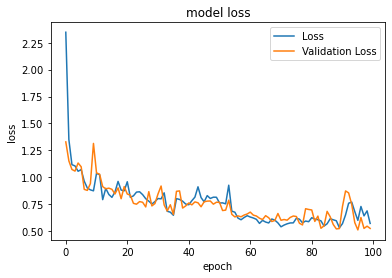

In [33]:
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [29]:
# get new predicted values with Hyperparameters
y_hp_pred = model.predict(X_test)

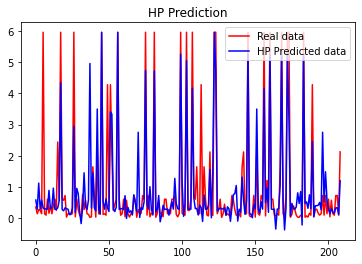

In [32]:
# plot predicted values against test values
plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(y_hp_pred, color = 'blue', label = 'HP Predicted data')
plt.title('HP Prediction')
plt.legend(loc='upper right')
plt.show()

In [31]:
# checking the output metrics
from sklearn import metrics


print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_hp_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_hp_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_hp_pred)))

y_mean = np.mean(y_hp_pred)
y_std = np.std(y_hp_pred)
print('Output Standard Deviation:', y_std)
print('Output Mean:', y_mean)

Mean Absolute Error: 0.5013727176793454
Mean Squared Error: 0.8304684533973672
Root Mean Squared Error: 0.9113004188506484
Output Standard Deviation: 1.4031942
Output Mean: 0.8911539
